In [1]:
import tensorflow as tf
import numpy as np
import os
import utils
import random as rn
import RGCN
from explaiNE import jaccard_score

In [2]:
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [3]:
data = np.load(os.path.join('..','data','royalty.npz'))

In [4]:
# triples,traces,nopred = utils.concat_triples(data, data['rules'])
# entities = data['all_entities'].tolist()
# relations = data['all_relations'].tolist()
RULE = 'aunt'

triples,traces,nopred = utils.concat_triples(data, [RULE,'brother','sister'])
sister_relations = data['sister_relations'].tolist()
sister_entities = data['sister_entities'].tolist()

brother_relations = data['brother_relations'].tolist()
brother_entities = data['brother_entities'].tolist()

entities = np.unique(data[RULE + '_entities'].tolist()+brother_entities+sister_entities).tolist()
relations = np.unique(data[RULE + '_relations'].tolist()+brother_relations+sister_relations).tolist()

# CONSTRUCT {
#     ?a dbo:uncle ?myuncle .
# }
# WHERE {
#     ?myuncle dbo:brother ?myparent .
#     ?a dbo:parent ?myparent . 
    
#     FILTER (!EXISTS {?a dbo:uncle ?myuncle})
# }

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [25]:
i = -1
print(triples[i])
print(traces[i])

['Princess_Clémentine_of_Belgium' 'aunt' 'Archduchess_Hermine_of_Austria']
[['Marie_Henriette_of_Austria' 'sister' 'Archduchess_Hermine_of_Austria']
 ['Princess_Clémentine_of_Belgium' 'parent' 'Marie_Henriette_of_Austria']
 ['UNK_ENT' 'UNK_REL' 'UNK_ENT']]


In [6]:
i = -1
# print(triples[i])
# print(traces[i])

plot_triples = np.concatenate([triples[i].reshape(1,3),traces[i].reshape(-1,3)], axis=0)
plot_triples = plot_triples[0:-1,:]
plot_triples

array([['Princess_Clémentine_of_Belgium', 'aunt',
        'Archduchess_Hermine_of_Austria'],
       ['Marie_Henriette_of_Austria', 'sister',
        'Archduchess_Hermine_of_Austria'],
       ['Princess_Clémentine_of_Belgium', 'parent',
        'Marie_Henriette_of_Austria']], dtype='<U76')

In [7]:
# G = nx.MultiDiGraph()
# for triple in plot_triples:
#     G.add_node(triple[0])
#     #G.add_node(triple[1])
#     G.add_node(triple[2])
#     G.add_edge(triple[0], triple[1])
#     G.add_edge(triple[1], triple[2])

# pos = nx.spring_layout(G)
# plt.figure(figsize=(6,4))
# nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
#         node_size=500, node_color='skyblue', alpha=0.9,
#         labels={node: node for node in G.nodes()})
# plt.axis('off')
# plt.show()

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


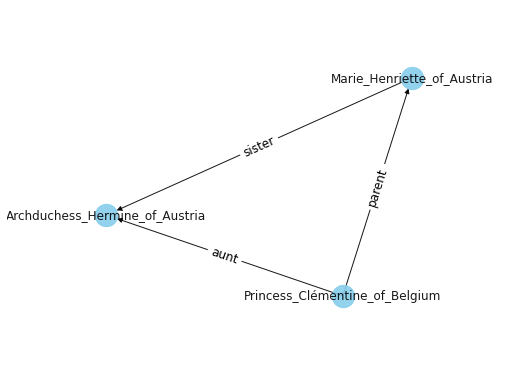

In [24]:
G = nx.MultiDiGraph()
for triple in plot_triples:
    G.add_node(triple[0])
    #G.add_node(triple[1])
    G.add_node(triple[2])
    #G.add_edge(triple[0], triple[1])
    #G.add_edge(triple[1], triple[2])
    G.add_edge(triple[0], triple[2])

pos = nx.spring_layout(G,seed=SEED)
#pos = nx.random_layout(G)
plt.figure(figsize=(7,5))

nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='skyblue', alpha=0.9,
        font_size=12,
        labels={node: node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels={('Princess_Clémentine_of_Belgium',
                                                 'Archduchess_Hermine_of_Austria'):'aunt',
('Marie_Henriette_of_Austria',
 'Archduchess_Hermine_of_Austria'):'sister',
('Princess_Clémentine_of_Belgium','Marie_Henriette_of_Austria'):'parent'},
                             font_color='black',font_size=12)
ax = plt.gca()
ax.margins(0.25)
plt.axis("off")
plt.savefig('../data/plots/example.pdf',bbox_inches='tight')
plt.show()

In [ ]:
NUM_ENTITIES = len(entities)
NUM_RELATIONS = len(relations)
EMBEDDING_DIM = 50
OUTPUT_DIM = 50

ALL_INDICES = tf.reshape(tf.range(0,NUM_ENTITIES,1,dtype=tf.int64), (1,-1))

ent2idx = dict(zip(entities, range(NUM_ENTITIES)))
rel2idx = dict(zip(relations, range(NUM_RELATIONS)))

In [ ]:
d = np.load(os.path.join('..','data','preds','explaine_'+RULE+'_preds.npz'))

new_traces = utils.array2idx(traces[d['test_idx']],ent2idx,rel2idx)

j = 0
num = d['preds'].shape[0]
for i in range(num):
    j += jaccard_score(new_traces[i],d['preds'][i],1)
print(j/num)

In [ ]:
model = RGCN.get_RGCN_Model(
    num_entities=NUM_ENTITIES,
    num_relations=NUM_RELATIONS,
    embedding_dim=EMBEDDING_DIM,
    output_dim=OUTPUT_DIM,
    seed=SEED
)

model.load_weights(os.path.join('..','data','weights',RULE+'.h5'))

# X = model.get_layer('entity_embeddings').get_weights()[0]
# S1 = 1.
# S2 = 1.5
# EMBEDDING_DIM = X.shape[1]
# GAMMA = (1/(S1**2)) - (1/(S2**2))

In [ ]:
in_file=np.load(os.path.join('..','data','preds','gnn_explainer_'+RULE+'_preds.npz'),allow_pickle=True)

In [ ]:
trace_length = 2

exp2idx = utils.array2idx(traces[in_file['test_idx']],ent2idx,rel2idx)
num_triples = exp2idx.shape[0]

true_exps = []
for i in range(num_triples):
    
    true_exps.append(exp2idx[i][0:trace_length,:])

true_exps = np.array(true_exps)

In [ ]:
explaine_in_file=np.load(os.path.join('..','data','preds','explaine_'+RULE+'_preds.npz'),allow_pickle=True)

In [ ]:
explaine_in_file['preds'].shape

In [ ]:
clean_preds = []
for i in range(in_file['preds'].shape[0]):
    preds_i = []
    for idx, j in enumerate(in_file['preds'][i]):
        if j.shape[0] > 0:
            rel = np.ones((j.shape[0]),dtype=np.int64) * idx
            preds_i.append(np.column_stack((j[:,0],rel,j[:,1])))            
    clean_preds.append(np.concatenate(preds_i, axis=0))

In [ ]:
len(clean_preds)

In [ ]:
precision = 0.0
recall = 0.0

for i in range(num_triples):
    
    current_tp = 0.0
    current_fp = 0.0
    current_fn = 0.0
    
    true_exp = true_exps[i]
    current_preds = clean_preds[i]
    
    #print('pred size', current_preds.shape)
    
    for pred_row in current_preds:
        
        for true_row in true_exp:
            
            reversed_row = true_row[[2,1,0]]
            
            if (pred_row == true_row).all() or (pred_row == reversed_row).all():
                current_tp += 1
            elif (pred_row != true_row).all() or (pred_row != reversed_row).all():
                current_fp += 1
                
            if (current_preds == true_row).all(axis=1).sum() >= 1:
                #this means true explanation triple is in set of predicitons
                pass
            else:
                current_fn += 1
    
    current_precision = current_tp / (current_tp + current_fp)
    current_recall = current_tp / (current_tp + current_fn)
    
    precision += current_precision
    recall += current_recall
     
precision /= num_triples
recall /= num_triples

print('precision',precision)
print('recall',recall)

In [ ]:
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)

In [ ]:
#add relation to triple array (clean up preds)
#add reverse triples to ground truth explanation
#compute precision, recall for test set

In [ ]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3,shuffle=True,random_state=SEED)
# indices = [(train_idx,test_idx) for train_idx,test_idx in kf.split(X=triples)]

In [ ]:
# train_idx,test_idx = indices[-1]

# train2idx = utils.array2idx(triples[train_idx],ent2idx,rel2idx)
# trainexp2idx = utils.array2idx(traces[train_idx],ent2idx,rel2idx)
# nopred2idx = utils.array2idx(nopred,ent2idx,rel2idx)

# test2idx = utils.array2idx(triples[test_idx],ent2idx,rel2idx)
# testexp2idx = utils.array2idx(traces[test_idx],ent2idx,rel2idx)

# ADJACENCY_DATA = tf.concat([
#     train2idx,
#     trainexp2idx.reshape(-1,3),
#     nopred2idx,
#     test2idx,
#     testexp2idx.reshape(-1,3)
#     ],axis=0
# )

In [ ]:
in_file['preds'][0]

In [ ]:
#adj_mats = utils.get_adj_mats(ADJACENCY_DATA,NUM_ENTITIES,NUM_RELATIONS)

In [ ]:
# tf_data = tf.data.Dataset.from_tensor_slices(
#             (test2idx[:,0],test2idx[:,1],test2idx[:,2],testexp2idx)).batch(1)

# for head,rel,tail,exp in tf_data:
#     print(head,rel,tail,exp)
#     break

In [ ]:
# with tf.GradientTape(watch_accessed_variables=False,persistent=True) as tape:
    
#     tape.watch(adj_mats)
    
#     pred = model([
#         ALL_INDICES,
#         tf.reshape(head,(1,-1)),
#         tf.reshape(rel,(1,-1)),
#         tf.reshape(tail,(1,-1)),
#         adj_mats
#         ]
#     )

In [ ]:
# def get_pred_indices(tape,pred,adj_mats_i,top_k):
#     scores = []
#     for idx, score in enumerate(tape.gradient(pred,adj_mats_i.values).numpy()):
#         if score:
#             scores.append((idx,score))
    
#     sorted_scores = sorted(scores, key=lambda x : x[1],reverse=True)[0:top_k]

#     return [idx for idx,_ in sorted_scores]

In [ ]:
top_k = 2
scores = []
for i in range(NUM_RELATIONS):
        
    adj_mat_i = adj_mats[i]
        
    for idx, score in enumerate(tape.gradient(pred,adj_mat_i.values).numpy()):
        if score:
            scores.append((idx,i,score))

In [ ]:
top_k_scores = sorted(scores, key=lambda x : x[2],reverse=True)[:top_k]

pred_triples = []

for idx,rel,score in top_k_scores:
    
    indices =  adj_mats[rel].indices.numpy()[idx,1:]

    head,tail = indices
    
    pred_triple = [head,rel,tail]
    
    pred_triples.append(pred_triple)

np.array(pred_triples)

In [ ]:
def get_preds(adj_mats,num_relations,top_k,tape,pred):
    
    scores = []
    
    for i in range(num_relations):
        
        adj_mat_i = adj_mats[i]
        
        for idx,score in enumerate(tape.gradient(pred,adj_mat_i.values).numpy()):
            if score:
                scores.append((idx,i,score))
                
    top_k_scores = sorted(scores, key=lambda x : x[2],reverse=True)[:top_k]
    
    pred_triples = []
    
    for idx,rel,score in top_k_scores:
        
        indices =  adj_mats[rel].indices.numpy()[idx,1:]

        head,tail = indices

        pred_triple = [head,rel,tail]

        pred_triples.append(pred_triple)

    return np.array(pred_triples)

In [ ]:
pred_exp = get_preds(adj_mats,NUM_RELATIONS,2,tape,pred)
pred_exp

In [ ]:
def jaccard_score(true_exp,pred_exp,top_k):

    true_exp = true_exp[:top_k]

    num_true_traces = true_exp.shape[0]
    num_pred_traces = pred_exp.shape[0]

    count = 0
    for pred_row in pred_exp:
        for true_row in true_exp:
            if (pred_row == true_row).all():
                count +=1

    score = count / (num_true_traces + num_pred_traces-count)
    
    return score

In [ ]:
testexp2idx[0][:top_k]

In [ ]:
jaccard_score(pred_exp,pred_exp,2)

In [ ]:
d = np.load(os.path.join('..','data','preds','explaine_'+RULE+'_preds.npz'))

In [ ]:
d.files

In [ ]:
j = 0

new_traces = utils.array2idx(traces[d['test_idx']],ent2idx,rel2idx)

num = d['preds'].shape[0]
for i in range(num):
    j += jaccard_score(new_traces[i],d['preds'][i],1)

print(j/num)

In [ ]:
utils.array2idx(traces[in_file['test_idx']],ent2idx,rel2idx)

In [ ]:
# new_pred = np.array([[0,850,920],[0,920,850],[0,920,8505],[0,8505 ,920]])

# new_exp = np.array([[0,920,8505],[0,8505 ,920]])

# num_true_traces = new_exp.shape[0]
# num_pred_traces = new_pred.shape[0]

# count = 0
# for pred_row in new_pred:
#     for true_row in new_exp:
#         if (pred_row == true_row).all():
#             count +=1

# count / (num_true_traces + num_pred_traces-count)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
ent2idx = dict(zip(entities, range(NUM_ENTITIES)))
rel2idx = dict(zip(relations, range(NUM_RELATIONS)))

idx2ent = dict(zip(range(NUM_ENTITIES),entities))

In [ ]:
pred_data = np.load(os.path.join('..','data','preds','explaine_'+RULE+'_preds.npz'))

In [ ]:
best_idx = int(pred_data['best_idx'])

In [ ]:
kf = KFold(n_splits=3,shuffle=True,random_state=SEED)

In [ ]:
cf_data = [test_idx for _, test_idx in kf.split(X=triples)]

In [ ]:
idx = cf_data[best_idx]

cv_triples = triples[idx]
cv_traces = traces[idx]

In [ ]:
test2idx = utils.array2idx(cv_triples,ent2idx,rel2idx)
testexp2idx = utils.array2idx(cv_traces,ent2idx,rel2idx)[:,:,[0,2]]

In [ ]:
preds = pred_data['preds']

In [ ]:
jaccard, scores = explaiNE.jaccard_score(testexp2idx,preds,TOP_K,return_scores=True)

In [ ]:
error_idx = scores < 0.5

In [ ]:
error_triples = cv_triples[error_idx]
error_traces = cv_traces[error_idx]

In [ ]:
i = 0
print(error_triples[i])
print(error_traces[i][0:TOP_K,])
print(idx2ent[preds[i][0][0]],idx2ent[preds[i][0][1]])

In [ ]:
model.load_weights(os.path.join('..','data','weights',RULE+'.h5'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [ ]:
jaccard_scores = []
preds = []

train2idx = utils.array2idx(triples,ent2idx,rel2idx)
trainexp2idx = utils.array2idx(traces,ent2idx,rel2idx)
nopred2idx = utils.array2idx(nopred,ent2idx,rel2idx)

#adjacency_data = tf.concat([train2idx,trainexp2idx.reshape(-1,3),nopred2idx],axis=0)

test2idx = utils.array2idx(triples,ent2idx,rel2idx)
testexp2idx = utils.array2idx(traces,ent2idx,rel2idx)

In [ ]:
adjacency_data = tf.concat([
    train2idx,
    trainexp2idx.reshape(-1,3),
    nopred2idx,
    test2idx,
    testexp2idx.reshape(-1,3)
    ],axis=0
)


In [ ]:
adjacency_data[adjacency_data[:,0] == h]

In [ ]:
true_subgraphs_list = [utils.get_adj_mats(testexp2idx[i],NUM_ENTITIES,NUM_RELATIONS) for i in range(testexp2idx.shape[0])]

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
d = tf.data.Dataset.from_tensor_slices((test2idx[:,0],test2idx[:,1],test2idx[:,2],testexp2idx)).batch(1)

dist_dataset = strategy.experimental_distribute_dataset(d)

# for h,r,t,l in dist_dataset:
#     print(h,r,t,tf.squeeze(l,axis=0))
#     break

In [ ]:
true_subgraphs = true_subgraphs_list[0]

In [ ]:
# for row in true_subgraphs[5].indices:
#     print(row)

tf.reduce_all(true_subgraphs[5].indices[0] == true_subgraphs[5].indices[0])

In [ ]:
def tf_jaccard(true_exp,pred_exp):
    
    num_true_traces = true_exp.shape[0]
    num_pred_traces = pred_exp.shape[0]
    
    count = 0
    for pred_row in pred_exp:
        for true_row in true_exp:
            if tf.reduce_all(pred_row == true_row):
                count += 1
    score = count / (num_true_traces + num_pred_traces-count)
    
    return score

In [ ]:
tf.cond(tf.reduce_all(true_subgraphs[5].indices[0]==true_subgraphs[5].indices[0]), lambda :1, lambda:0)

In [ ]:
#true_subgraphs[5].indices
tf.boolean_mask(train2idx,train2idx[:,0] == 167)

In [ ]:
train2idx[train2idx[:,0] == 167]

In [ ]:
from sklearn.metrics import jaccard_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold

In [ ]:
all_indices = tf.reshape(tf.range(0,NUM_ENTITIES,1,dtype=tf.int64), (1,-1))

model = RGCN.get_RGCN_Model(
    num_entities=NUM_ENTITIES,
    num_relations=NUM_RELATIONS,
    embedding_dim=EMBEDDING_DIM,
    output_dim=OUTPUT_DIM,
    seed=SEED
)

model.load_weights(os.path.join('..','data','weights',RULE+'.h5'))
#kf = KFold(n_splits=3,shuffle=True,random_state=SEED)
cv_scores = []
cv_preds = []

masks = [tf.Variable(
        initial_value=tf.random.normal(
            (1,NUM_ENTITIES,NUM_ENTITIES), 
            mean=0, 
            stddev=1, 
            dtype=tf.float32, 
            seed=SEED),
        name='mask_'+str(i),
        trainable=True) for i in range(NUM_RELATIONS)
]

In [ ]:
masks[0].assign(tf.random.normal(
            (1,NUM_ENTITIES,NUM_ENTITIES), 
            mean=0, 
            stddev=1, 
            dtype=tf.float32, 
            seed=SEED))

In [ ]:
test2idx = tf.expand_dims(test2idx,axis=0)

jaccard_scores = []
preds = []

adj_mats = utils.get_adj_mats(adjacency_data, NUM_ENTITIES,NUM_RELATIONS)

for epoch in range(NUM_EPOCHS):

    with tf.GradientTape(watch_accessed_variables=False) as tape:

        tape.watch(masks)

        masked_adjs = [adj_mats[i] * tf.sigmoid(masks[i]) for i in range(NUM_RELATIONS)]

        test_preds =  model([
            all_indices,
            test2idx[:,0:2,0],
            test2idx[:,0:2,1],
            test2idx[:,0:2,2],
            masked_adjs
            ]
        )

        loss = tf.reduce_mean(-1 * tf.math.log(test_preds+0.00001))#+ tf.reduce_mean(masks)

    print(f"Loss {loss} @ epoch {epoch}")
    grads = tape.gradient(loss,masks)
    optimizer.apply_gradients(zip(grads,masks))

In [ ]:
def score_subgraphs(
    true_subgraphs,
    adj_mats,
    masks,
    num_relations,
    num_entities,
    threshold
    ):
    
    '''Compute jaccard score across all relations for one triple'''

    scores = []
    pred_graphs = []

    for i in range(num_relations):

        mask_i = adj_mats[i] * tf.nn.sigmoid(masks[i])

        non_masked_indices = tf.gather(mask_i.indices[mask_i.values > threshold], [1,2],axis=1)

        if non_masked_indices.shape[0]:

            pred_graph = csr_matrix(
                (tf.ones(non_masked_indices.shape[0]),(non_masked_indices[:,0],non_masked_indices[:,1])),
                shape=(num_entities,num_entities)
            )

            pred_graphs.append(non_masked_indices)

        else:

            pred_graph = csr_matrix(([],([],[])),shape=(num_entities,num_entities))
            pred_graphs.append([])

        true_indices = true_subgraphs[i].indices

        if true_indices.shape[0]:

            gather = tf.gather(true_indices,[1,2],axis=1)

            true_graph = csr_matrix(
                (true_subgraphs[i].values,(gather[:,0],gather[:,1])),
                shape=(num_entities,num_entities))

        else:
            true_graph = csr_matrix(([],([],[])),shape=(num_entities,num_entities))


        score = jaccard_score(true_graph,pred_graph,average='micro')

        scores.append(score)

    return tf.reduce_mean(scores[1:]), pred_graphs

In [ ]:
true_subgraphs = utils.get_adj_mats(testexp2idx[0],NUM_ENTITIES,NUM_RELATIONS)

In [ ]:
# jaccard, _ = score_subgraphs(
#     true_subgraphs=true_subgraphs,
#     adj_mats=adj_mats,
#     masks=masks,
#     num_relations=NUM_RELATIONS,
#     num_entities=NUM_ENTITIES,
#     threshold=THRESHOLD
# )


In [ ]:
for i in range(NUM_RELATIONS):
    
    print(tf.sparse.to_dense(adj_mats[i]).numpy().sum())
    print(tf.nn.sigmoid(masks[i]).numpy().sum())
    mask_i = adj_mats[i] * tf.nn.sigmoid(masks[i])

    non_masked_indices = tf.gather(mask_i.indices[mask_i.values > THRESHOLD], [1,2],axis=1)

In [ ]:
-1*tf.math.log(test_preds)

In [ ]:
mask_i = true_subgraphs[5] * tf.nn.sigmoid(masks[5])

In [ ]:
tf.reduce_sum(tf.cast(tf.sigmoid(true_subgraphs[5].values) > .5,dtype=tf.float32))

In [ ]:
RULE = 'spouse'
sister_relations = data['sister_relations'].tolist()
sister_entities = data['sister_entities'].tolist()

brother_relations = data['brother_relations'].tolist()
brother_entities = data['brother_entities'].tolist()

entities = np.unique(data[RULE + '_entities'].tolist()+brother_entities+sister_entities).tolist()
relations = np.unique(data[RULE + '_relations'].tolist()+brother_relations+sister_relations).tolist()


In [ ]:
pred_exp = tf.convert_to_tensor(np.array([[0,922,8507],[0,0,0],[0,1,1]]))
pred_exp

In [ ]:
true_exp = mask_i.indices[mask_i.values > .5]
true_exp

In [ ]:
#tf.cast(tf.reduce_sum(tf.cast(mask_i.values > .5,dtype=tf.float32)),dtype=tf.int32)
#mask_i.indices[mask_i.values > .5]
# def fun(x):
#     print(x)
#     other = mask_i.indices[mask_i.values > .5]
#     print('equality',tf.equal(x,other))
#     return tf.reduce_all(tf.equal(x,other),axis=1)
# tf.map_fn(fn=fun,elems=mask_i.indices[mask_i.values > .5],dtype=tf.bool)

def outer(x):
    def inner(y):
#         print('x',x)
#         print('y',y)
#         print('equality',tf.reduce_all(tf.equal(x,y)))
        return tf.reduce_all(tf.equal(x,y))
    
    return tf.map_fn(fn=inner,elems=pred_exp,dtype=tf.bool)

tf.reduce_sum(tf.cast(tf.map_fn(fn=outer,elems=true_exp,
                                dtype=tf.bool),dtype=tf.float32),axis=1)

In [ ]:
#     test2idx = tf.expand_dims(test2idx,axis=0)

#     jaccard_scores = []
#     preds = []

#     adj_mats = utils.get_adj_mats(adjacency_data, NUM_ENTITIES,NUM_RELATIONS)

#     for epoch in range(NUM_EPOCHS):

#         with tf.GradientTape(watch_accessed_variables=False) as tape:

#             tape.watch(masks)

#             masked_adjs = [adj_mats[i] * tf.sigmoid(masks[i]) for i in range(NUM_RELATIONS)]

#             test_preds =  model([
#                 all_indices,
#                 test2idx[:,0:2,0],
#                 test2idx[:,0:2,1],
#                 test2idx[:,0:2,2],
#                 masked_adjs
#                 ]
#             )

#             penalty = tf.reduce_sum([tf.reduce_sum(
#                 tf.cast(masked_adjs[i].values > .5,dtype=tf.int64)) for i in range(NUM_RELATIONS)])

#             loss = tf.reduce_mean(-1 * tf.math.log(test_preds+0.00001)) + (.001 * penalty.numpy())#+ tf.reduce_mean(masks)

#         print(f"Loss {tf.reduce_mean(loss)} @ epoch {epoch}")

#         grads = tape.gradient(loss,masks)
#         optimizer.apply_gradients(zip(grads,masks))

#     j_scores = []

#     #for i in range(testexp2idx.shape[0]):
#     for i in range(2):

#         true_subgraphs = utils.get_adj_mats(testexp2idx[i],NUM_ENTITIES,NUM_RELATIONS)

#         jaccard, _ = score_subgraphs(
#             true_subgraphs=true_subgraphs,
#             adj_mats=adj_mats,
#             masks=masks,
#             num_relations=NUM_RELATIONS,
#             num_entities=NUM_ENTITIES,
#             threshold=THRESHOLD
#         )

#         j_scores.append(jaccard)
#         #preds.append(pred)

#     cv_avg = tf.reduce_mean(j_scores)
#     print(f"Cv jaccard scores {cv_avg}")

#     cv_scores.append(cv_avg)
#     #cv_preds.append(preds)


# best_idx = np.argmin(cv_scores)
# #best_preds = cv_preds[best_idx]

# print(f"Overall jaccard score: {tf.reduce_mean(cv_scores)}")

In [ ]:
# np.savez(os.path.join('..','data','preds','gnn_explainer_'+RULE+'_preds.npz'),
#     preds=pred_graphs,embedding_dim=EMBEDDING_DIM,k=K,
#     threshold=THRESHOLD,learning_rate=LEARNING_RATE,num_epochs=NUM_EPOCHS
#     )

In [ ]:
import numpy as np
import os
in_file=np.load(os.path.join('..','data','preds','gnn_explainer_'+'spouse'+'_preds.npz'),allow_pickle=True)

In [ ]:

# head_output = tf.matmul(tf.reshape(entity_embeddings[head],(1,-1)),self_kernel)
# tail_output = tf.matmul(tf.reshape(entity_embeddings[tail],(1,-1)),self_kernel)

# for i in range(NUM_RELATIONS):

#     adj_i = tf.sparse.to_dense(adj_mats[i])[0] * tf.sigmoid(masks[i][0])

#     sum_embeddings = tf.matmul(adj_i,entity_embeddings)

#     head_update = tf.reshape(sum_embeddings[head],(1,-1))
#     tail_update = tf.reshape(sum_embeddings[tail],(1,-1))

#     head_output += tf.matmul(head_update,relation_kernel[i])
#     tail_output += tf.matmul(tail_update,relation_kernel[i])

# # for i in range(NUM_RELATIONS):

# #     adj_i = tf.sparse.reshape(adj_mats[i] * tf.sigmoid(masks[i]), (NUM_ENTITIES,NUM_ENTITIES))

# head_output = tf.sigmoid(head_output)
# tail_output = tf.sigmoid(tail_output)

# pred = tf.sigmoid(tf.reduce_sum(head_output*relation_kernel[rel]*tail_output))